In [1]:
import os
import random
import osmnx as ox
import geopandas as gpd
import pandas as pd
import folium

random.seed(42)

# ============================================================
# 1. BAIXAR MALHA VIÁRIA DE BELÉM
# ============================================================
print("Baixando ruas de Belém...")
G = ox.graph_from_place("Belém, Pará, Brazil", network_type="drive")
edges = ox.graph_to_gdfs(G, nodes=False, edges=True)

Baixando ruas de Belém...


In [2]:
# ============================================================
# 2. FUNÇÃO: GERAR PONTO ALEATÓRIO EM UMA RUA
# ============================================================
def gerar_ponto_aleatorio_em_rua(geom):
    distancia_random = random.uniform(0, geom.length)
    return geom.interpolate(distancia_random)

# ============================================================
# 3. CARREGAR SHAPE DOS BAIRROS
# ============================================================
path = "/home/akel/PycharmProjects/Data_ambiental/data/process/"
arquivo = os.path.join(path, "shape_bairros.gpkg")

gdf_bairros = gpd.read_file(arquivo).rename(columns={'NM_BAIRRO': 'Bairro'})
bairros4674 = gdf_bairros.to_crs("EPSG:4674")
edges = edges.to_crs("EPSG:4674")

# ============================================================
# 4. CARREGAR TABELA DE DESCARTES IRREGULARES ML
# ============================================================
df_temp = pd.read_csv(os.path.join(path, "Descartes_RF.csv"))
df_descartes = (
    df_temp[['Bairro', 'Depósitos Irregulares est.']]
    .rename(columns={'Depósitos Irregulares est.': 'N_descartes'})
)

lista_bairros = df_descartes['Bairro'].tolist()

# Reset de índices para evitar problemas no overlay
edges = edges.reset_index(drop=True)
bairros4674 = bairros4674.reset_index(drop=True)

# ============================================================
# 5. GERAR PONTOS ALEATÓRIOS POR BAIRRO
# ============================================================
pontos = []
ponto_bairro = []   # <- necessário para colorir depois

for bairro in lista_bairros:
    # Número de descartes no bairro
    N = int(df_descartes.loc[df_descartes["Bairro"] == bairro, "N_descartes"].iloc[0])

    # Seleciona o polígono do bairro
    bairro_geom = bairros4674[bairros4674["Bairro"] == bairro]

    # Interseção com ruas
    ruas_no_bairro = gpd.overlay(edges, bairro_geom, how="intersection")

    if ruas_no_bairro.empty:
        #print(f"⚠️ Sem ruas no bairro: {bairro}")
        continue

    # Gera N pontos aleatórios
    for _ in range(N):
        rua_escolhida = ruas_no_bairro.sample(1).iloc[0]
        ponto = gerar_ponto_aleatorio_em_rua(rua_escolhida.geometry)
        pontos.append(ponto)
        ponto_bairro.append(bairro)   # ← registrando o bairro do ponto


# ============================================================
# 6. CRIAR GEODataFrame DOS PONTOS
# ============================================================
gdf_pontos = gpd.GeoDataFrame(geometry=pontos, crs="EPSG:4326")
gdf_pontos["lat"] = gdf_pontos.geometry.y
gdf_pontos["lon"] = gdf_pontos.geometry.x


In [3]:
# ============================================================
# 7. CRIAR MAPA COM PONTOS
# ============================================================
centro = [gdf_pontos["lat"].mean(), gdf_pontos["lon"].mean()]
mapa = folium.Map(location=centro, zoom_start=12)

for _, row in gdf_pontos.iterrows():
    folium.CircleMarker(
        location=[row["lat"], row["lon"]],
        radius=4,
        color="red",
        fill=True,
        fill_color="red",
    ).add_to(mapa)

# Mostrar mapa
mapa

In [4]:
# ============================================================
# 6. CRIAR GEODataFrame DOS PONTOS
# ============================================================
gdf_pontos = gpd.GeoDataFrame(
    {"Bairro": ponto_bairro},
    geometry=pontos,
    crs="EPSG:4326"
)

gdf_pontos["lat"] = gdf_pontos.geometry.y
gdf_pontos["lon"] = gdf_pontos.geometry.x

# ============================================================
# 7. LISTA DE BAIRROS QUE FICARÃO EM AZUL
# ============================================================
bairros_azuis = [
    "Campina", "Cidade Velha", "Marco", "São Brás", "Umarizal", "Bengui",
    "Coqueiro", "São Clemente", "Tapanã", "Castanheira", "Marambaia",
    "Souza", "Val-de-Cães", "Guamá", "Jurunas", "Paracuri", "Ponta Grossa",
    "Miramar", "Pedreira", "Sacramenta", "Telégrafo"
]

# Define a cor de cada ponto
def cor_por_bairro(bairro):
    return "blue" if bairro in bairros_azuis else "red"

# ============================================================
# 8. CRIAR MAPA FOLIUM
# ============================================================
centro = [gdf_pontos["lat"].mean(), gdf_pontos["lon"].mean()]
mapa = folium.Map(location=centro, zoom_start=12, tiles="cartodbpositron")

# ============================================================
# 9. ADICIONAR PONTOS AO MAPA
# ============================================================
for _, row in gdf_pontos.iterrows():
    folium.CircleMarker(
        location=[row["lat"], row["lon"]],
        radius=4,
        color=cor_por_bairro(row["Bairro"]),
        fill=True,
        fill_color=cor_por_bairro(row["Bairro"]),
        fill_opacity=0.8,
        tooltip=f"{row['Bairro']}"
    ).add_to(mapa)

# Mostrar o mapa
mapa

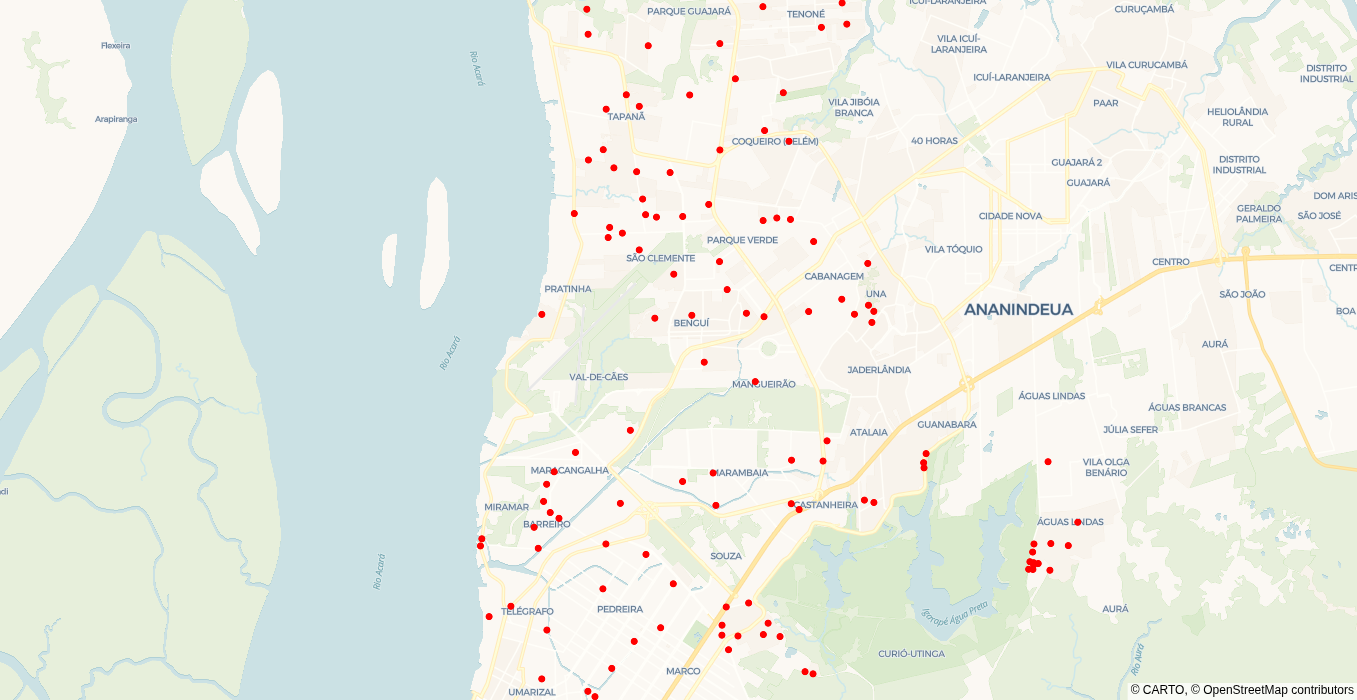

In [5]:
import geopandas as gpd
import pandas as pd
import plotly.express as px

# ============================================================
# 7. MAPA INTERATIVO COM PLOTLY
# ============================================================
centro_lat = gdf_pontos["lat"].mean()
centro_lon = gdf_pontos["lon"].mean()

fig = px.scatter_map(
    gdf_pontos,
    lat="lat",
    lon="lon",
    zoom=12,
    height=700,
)

fig.update_layout(
    mapbox_style="open-street-map",
    mapbox_center={"lat": centro_lat, "lon": centro_lon},
    margin={"r": 0, "t": 0, "l": 0, "b": 0}
)

fig.update_traces(marker=dict(size=8, color="red"))

fig.show()


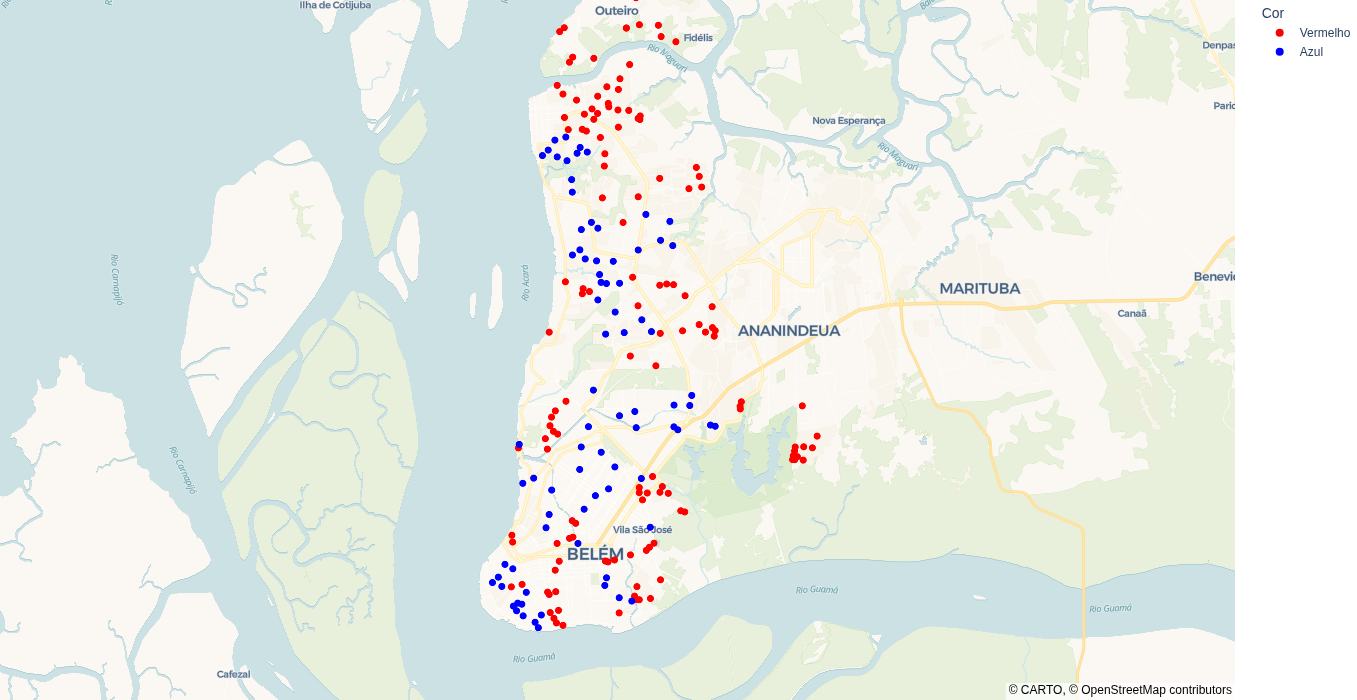

In [6]:

# criar coluna de categoria de cor
gdf_pontos["Cor"] = gdf_pontos["Bairro"].apply(
    lambda b: "Azul" if b in bairros_azuis else "Vermelho"
)

# ============================================================
# 8. MAPA INTERATIVO EM PLOTLY
# ============================================================
centro_lat = gdf_pontos["lat"].mean()
centro_lon = gdf_pontos["lon"].mean()

fig = px.scatter_map(
    gdf_pontos,
    lat="lat",
    lon="lon",
    color="Cor",
    hover_name="Bairro",
    color_discrete_map={"Azul": "blue", "Vermelho": "red"},
    zoom=11,
    height=700
)

fig.update_layout(
    mapbox_style="open-street-map",
    mapbox_center={"lat": centro_lat, "lon": centro_lon},
    margin={"r":0, "t":0, "l":0, "b":0}
)

fig.update_traces(marker=dict(size=8))

fig.show()
